In [ ]:
tf.__version__

'2.9.2'

In [7]:
import tensorflow.python.keras.optimizers

In [ ]:
!pip install xmltodict
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.4 MB/s 


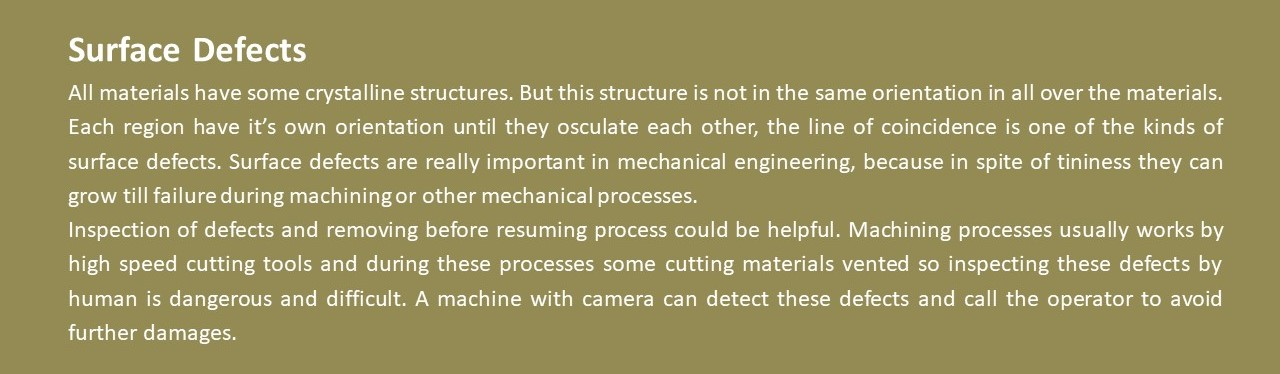

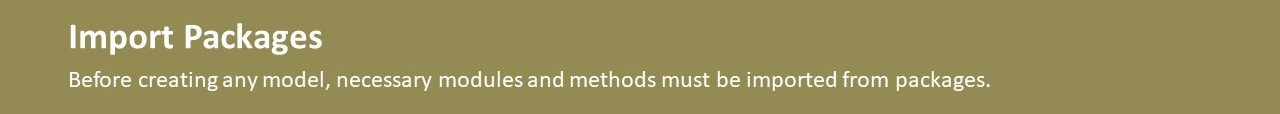

In [ ]:
import tensorflow as tf

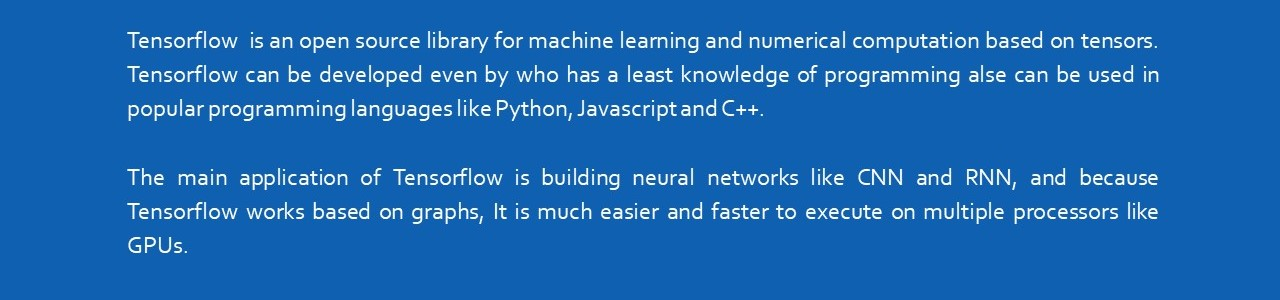

In [ ]:
import xmltodict

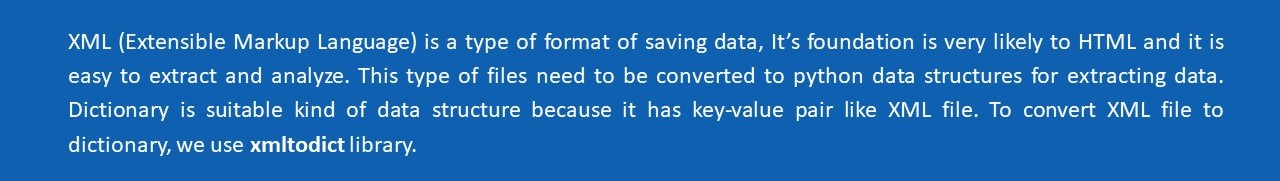

In [ ]:
import os

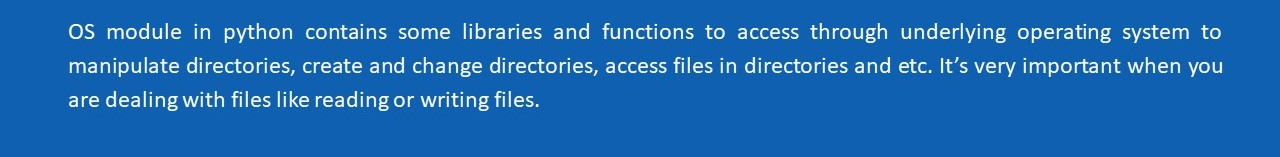

In [ ]:
import matplotlib.pyplot as plt

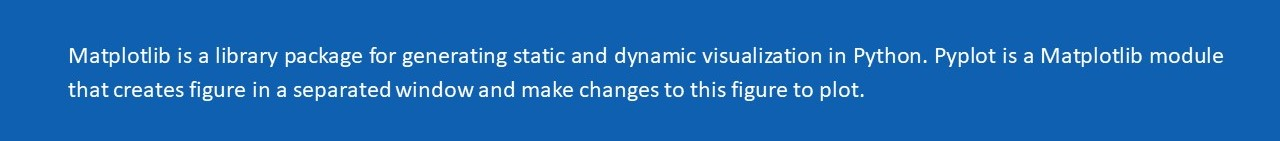

In [ ]:
import numpy as np

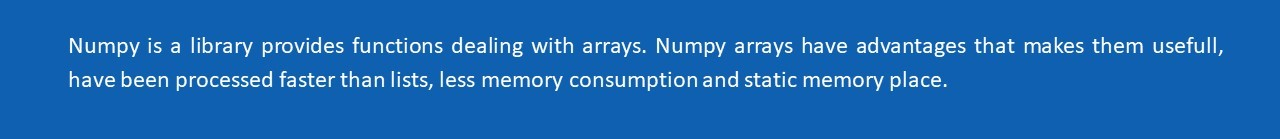

In [ ]:
import tensorflow_addons as tfa

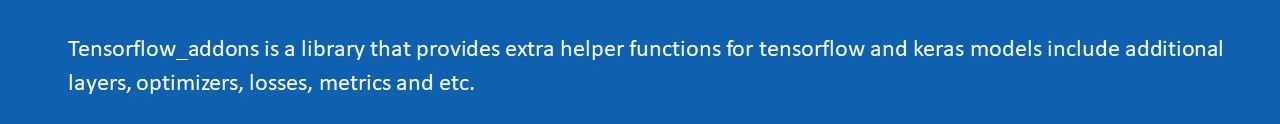

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten

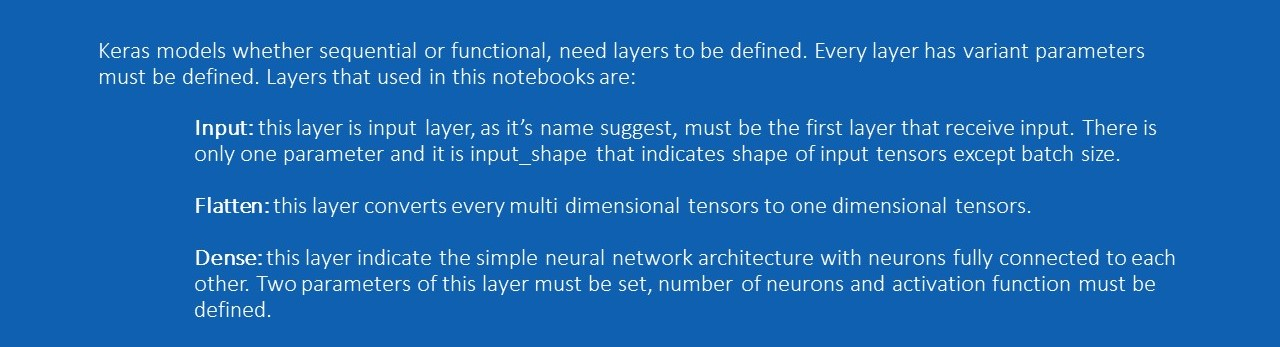

In [ ]:
from tensorflow.keras.applications import VGG16

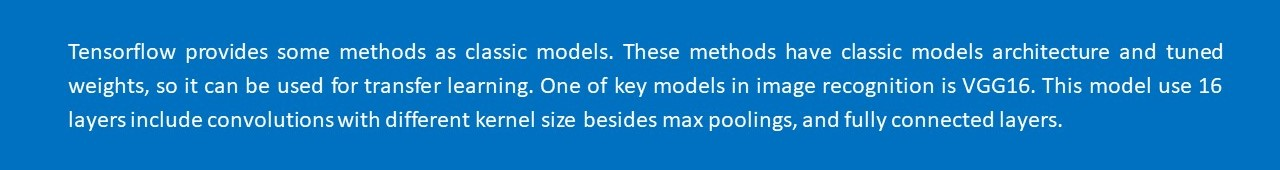

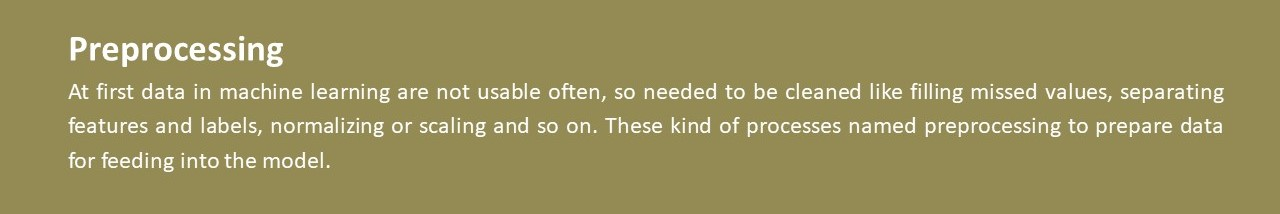

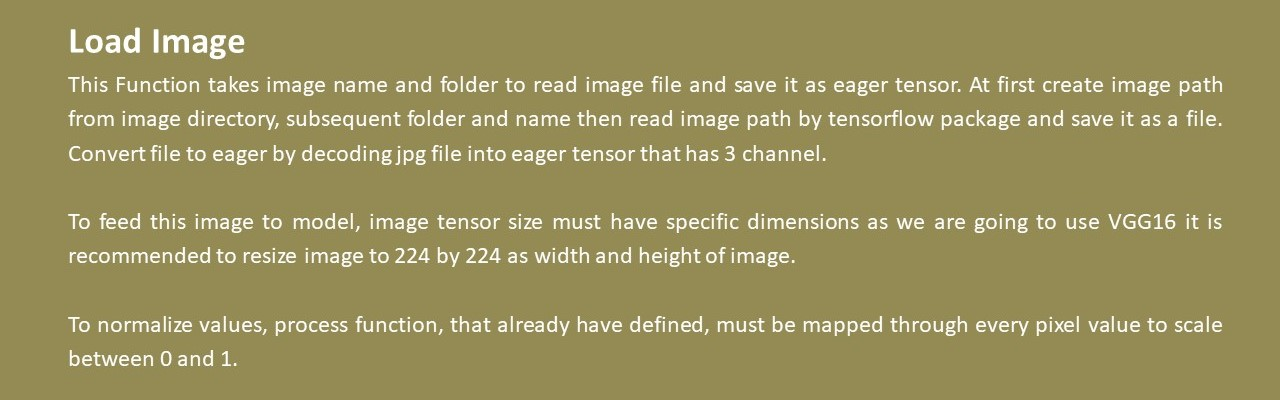

In [ ]:
def load_image(path, folder, img_dir = "/content/drive/MyDrive/Colab/AI book/Chapter 4/Chapter 4 Data/images/images"):
    img_path = os.path.join(img_dir, folder)
    img_path = os.path.join(img_path, path)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image/255., tf.float32)
    
    return image

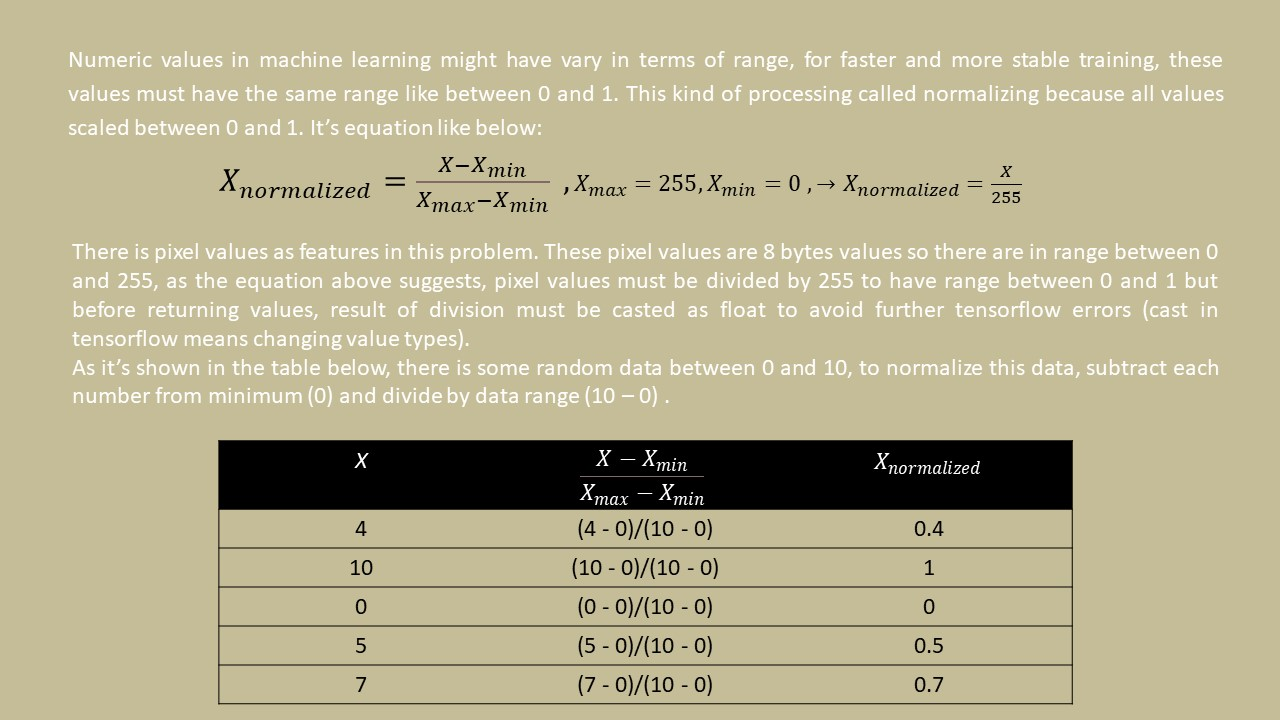

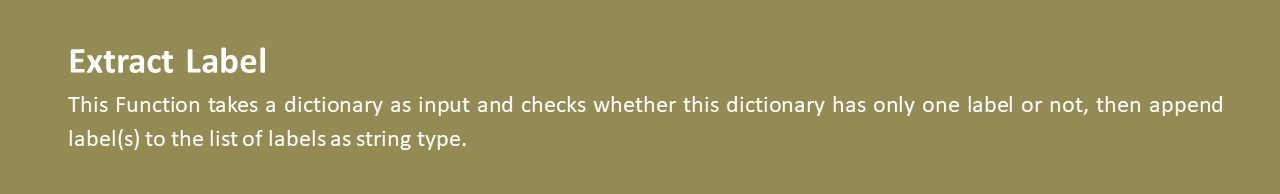

In [ ]:
def extract_label(label_dicts):
    labels = []
    
    if type(label_dicts) == dict:
        labels.append(int(label_dicts['name'].split("_")[0]))
    
    else:
        for label_dict in label_dicts:
            label = int(label_dict['name'].split("_")[0])
            if label not in labels:
                labels.append(label)

    return labels

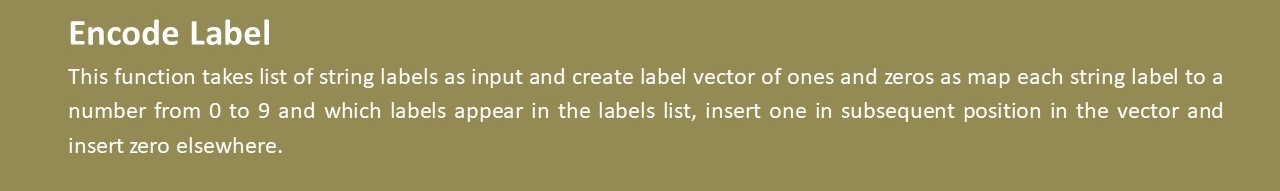

In [ ]:
def encode_label(labels):
  encoded_label = np.zeros(10)
  
  for label in labels:
    encoded_label[label-1] = 1
  encoded_label = tf.convert_to_tensor(encoded_label)
  
  return encoded_label

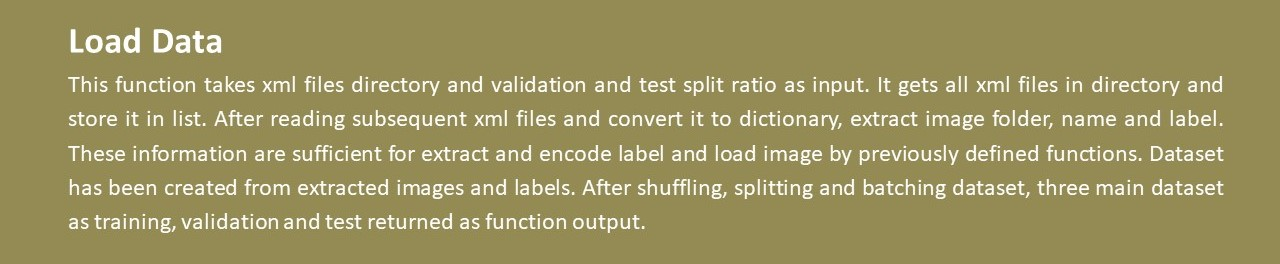

In [ ]:
def load_data(xml_dir = "/content/drive/MyDrive/Colab/AI book/Chapter 4/Chapter 4 Data/label/label", val_split_rate=0.1, test_split_rate=0.1):
    folders = [ 'punching_hole', 'welding_line', 'crescent_gap', 'water_spot', 'oil_spot', 'silk_spot', 'inclusion', 'rolled_pit', 'crease', 'waist folding']
    xmls = os.listdir(xml_dir)
    images = []
    labels = []

    for xml_path_r in xmls:
        xml_path_g = os.path.join(xml_dir, xml_path_r)
        
        with open(xml_path_g) as file:    
            data = xmltodict.parse(file.read())
            image_folder = data['annotation']['folder']
            image_name = data['annotation']['filename']
            label_dict = data['annotation']['object']
            if image_folder == 'all':
                
                for folder in folders:
                    try:    
                        image = load_image(image_name, folder)
                        label = extract_label(label_dict)
                        encoded_label = encode_label(label)
                    except:    
                        pass
            else:
                image_folder = folders[int(image_folder) - 1]
                image = load_image(image_name, image_folder)
                label = extract_label(label_dict)
                encoded_label = encode_label(label)
            images.append(image)
            labels.append(encoded_label)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(512)
    dataset_length = len(images)
    validation_size = int(val_split_rate*dataset_length)
    test_size = int(test_split_rate*dataset_length)
    training_dataset = dataset.skip(validation_size + test_size)
    validation_dataset = dataset.take(validation_size + test_size)
    test_dataset = validation_dataset.take(test_size)
    validation_dataset = validation_dataset.skip(test_size)
    training_dataset = training_dataset.batch(32)
    validation_dataset = validation_dataset.batch(32)
    test_dataset = test_dataset.batch(32)
    return training_dataset, validation_dataset, test_dataset


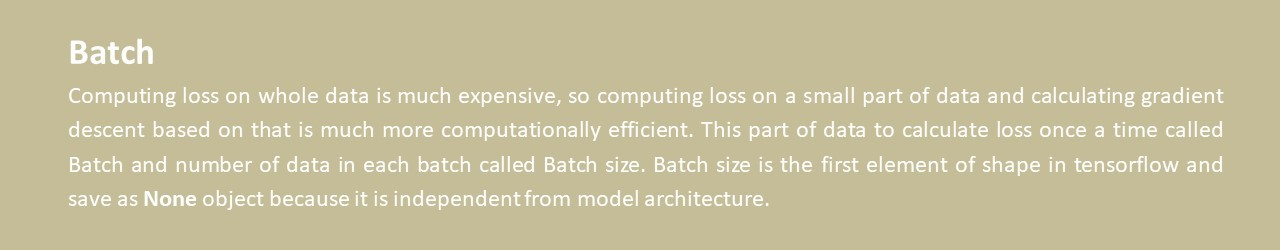

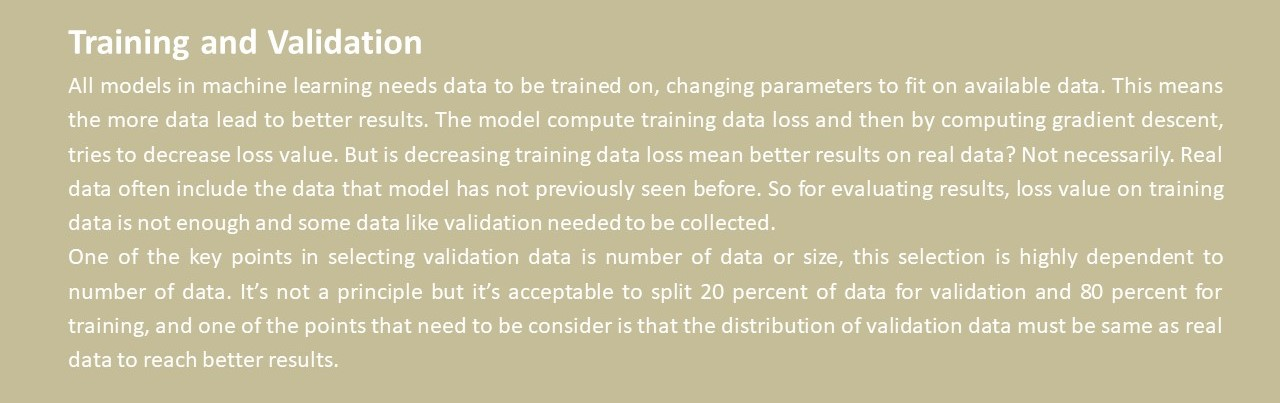

In [ ]:
train_data, val_data, test_data = load_data()

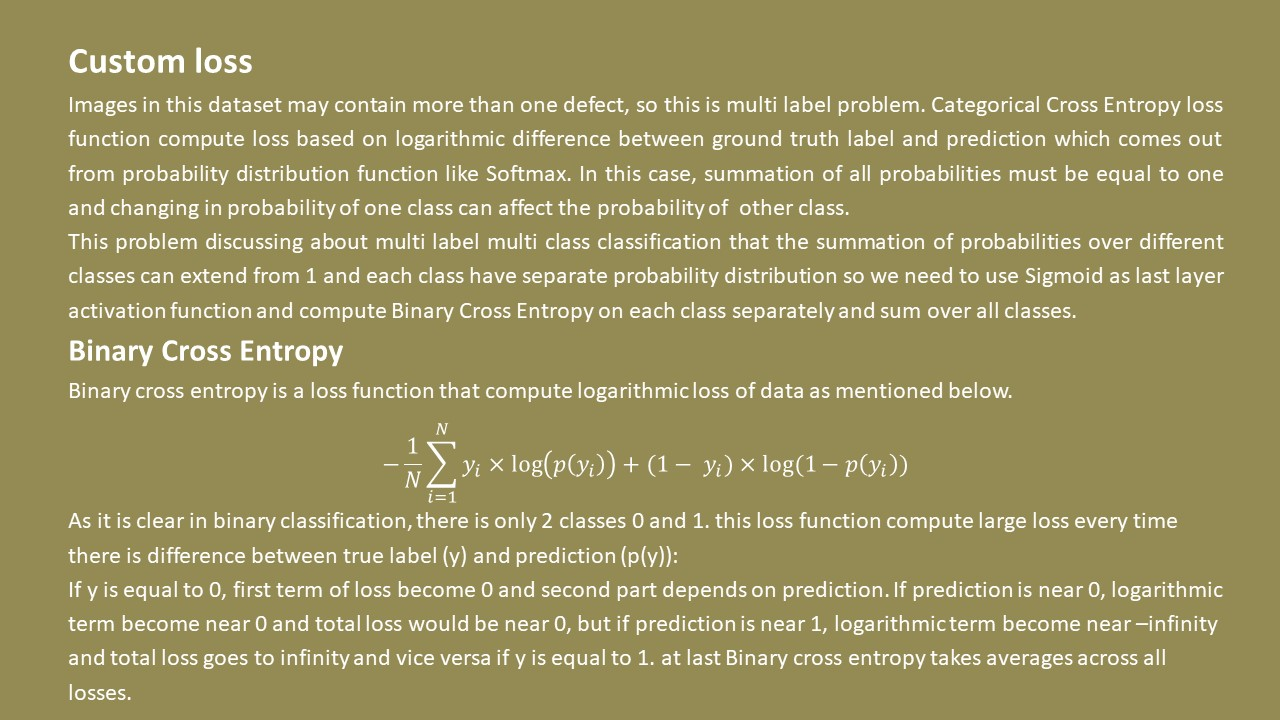

In [ ]:
class Custom_Loss(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__()
        self.bce = tf.keras.losses.BinaryCrossentropy()
        
    def call(self, y_true, y_pred):
      """
      y_true: labels of size (batch_size, number of categories)
      y_pred: model output of size (batch_size, number of categories)
      """
      bce = 0                                              #loss at the first stage
      for i in range(10): 
        bce += self.bce(y_true[:, i], y_pred[:, i])  #compute loss on every predicted word or numbers separately and get sum
      return bce

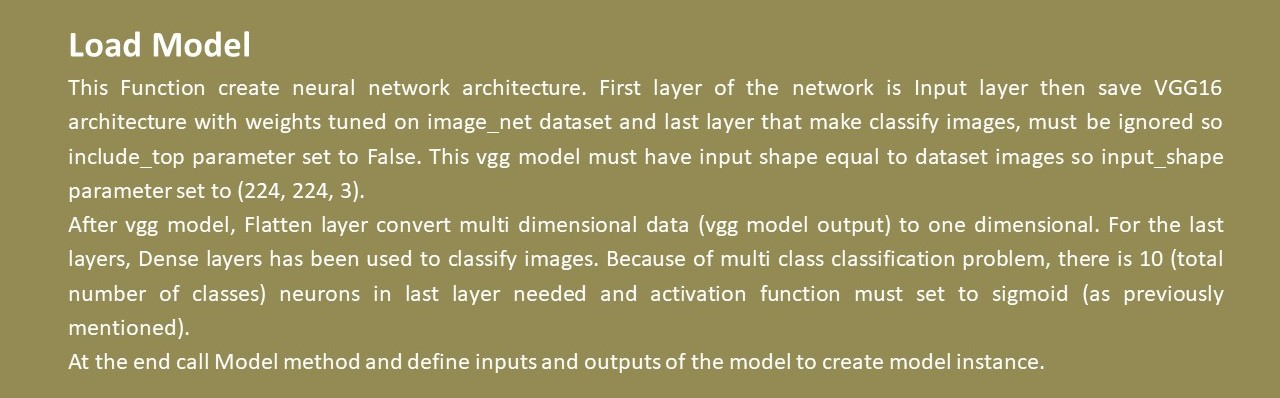

In [ ]:
def load_model():
  inputs = Input(shape=(224, 224, 3), batch_size=32, name='Input Layer')
  pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  for layer in pre_trained_model.layers:
    layer.trainable = False
  x = pre_trained_model(inputs)
  x = Flatten()(x)
  x = Dense(10, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, x)
  return model

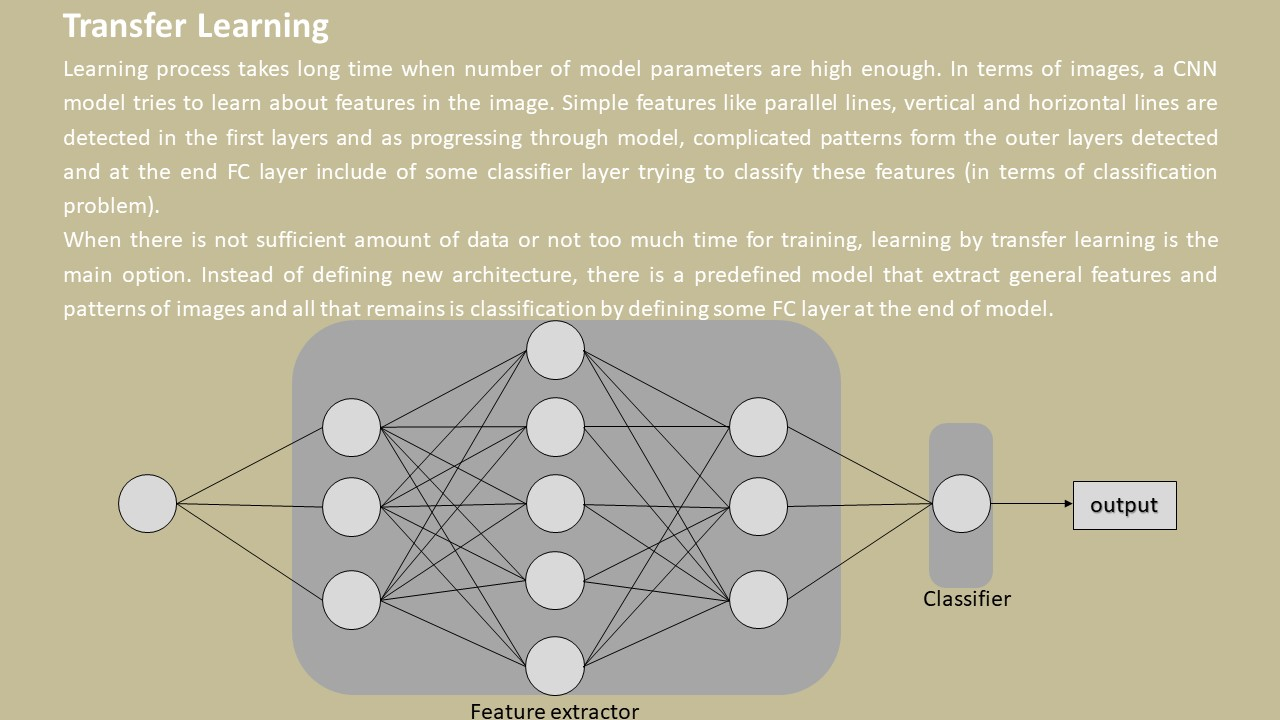

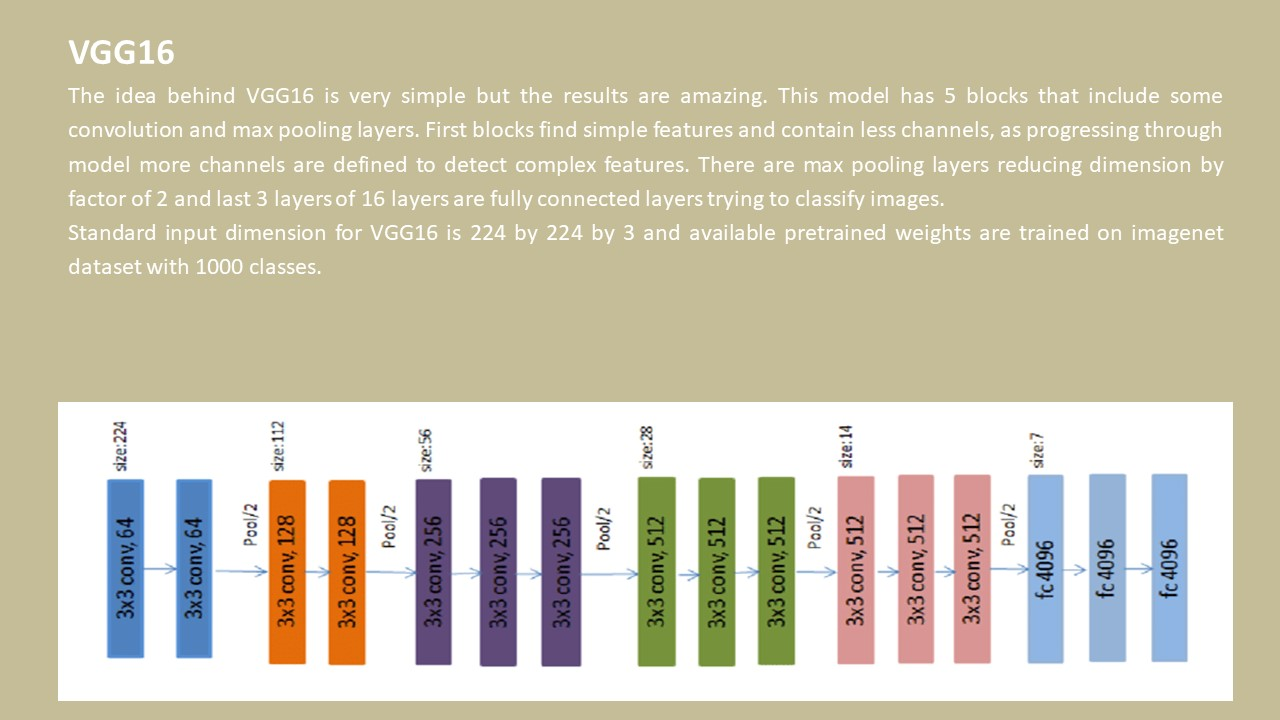

In [ ]:
model = load_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(32, 224, 224, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (32, 25088)               0         
                                                                 
 dense (Dense)               (32, 10)                  250890    
                                                                 
Total params: 14,965,578
Trainable params: 250,890
Non-trainable params: 14,714,688
_________________________________________________________________


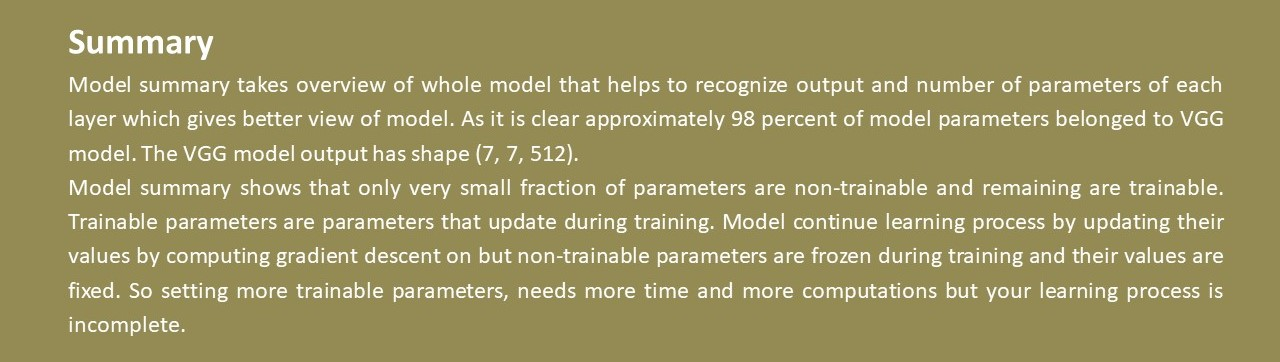

In [ ]:
model.compile(loss=Custom_Loss(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tfa.metrics.F1Score(10, threshold=0.5)])

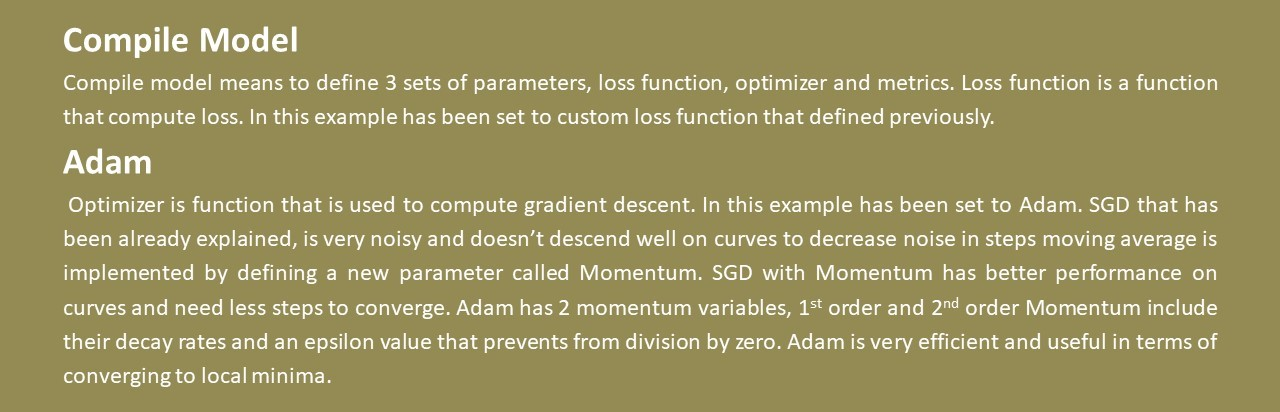

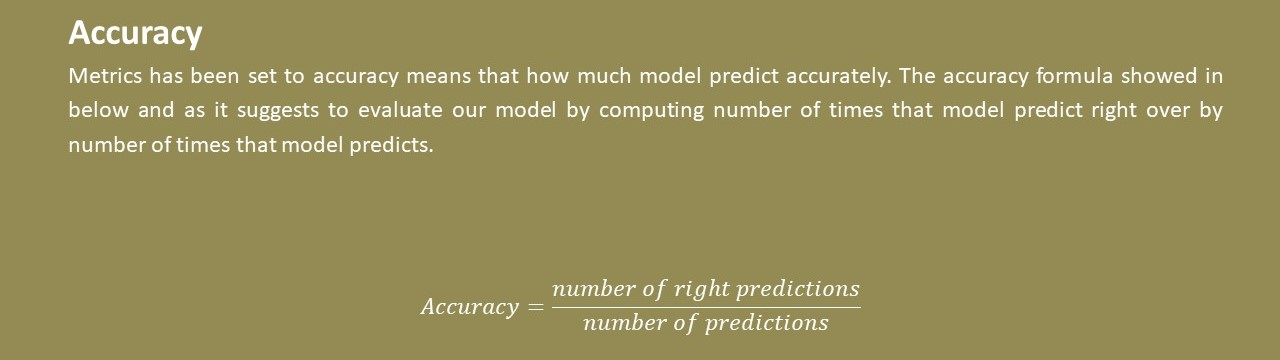

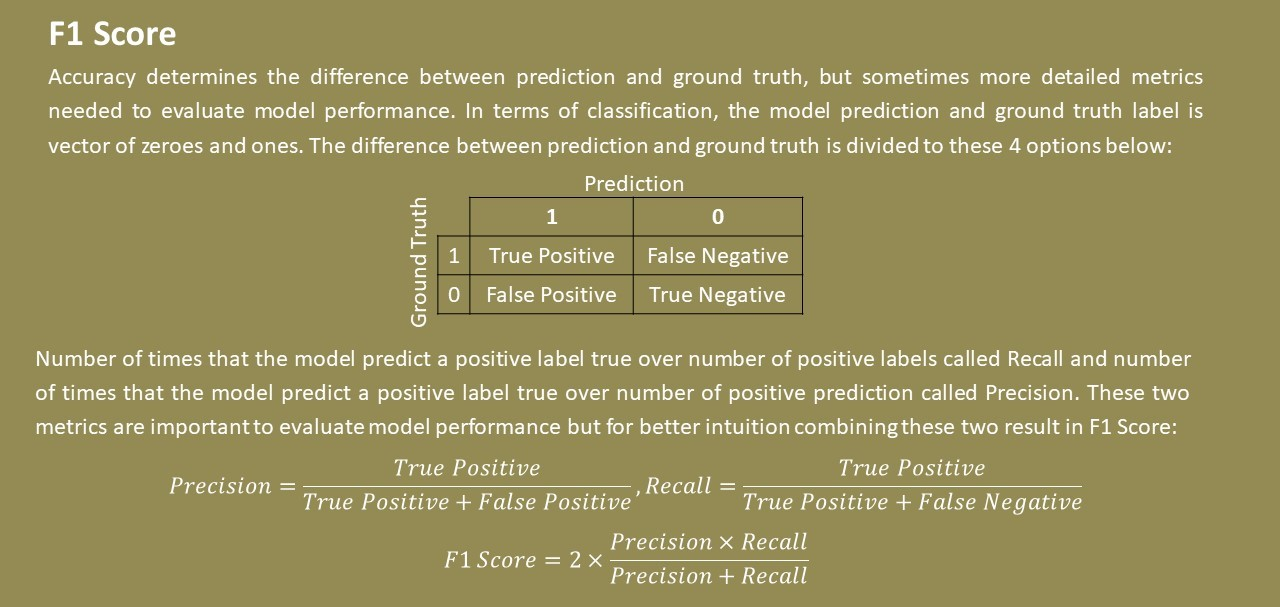

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
57/57 [==============================] - 24s 215ms/step - loss: 3.2149 - accuracy: 0.4232 - f1_score: 0.2210 - val_loss: 2.5428 - val_accuracy: 0.2969 - val_f1_score: 0.2583
Epoch 2/50
57/57 [==============================] - 10s 170ms/step - loss: 2.1512 - accuracy: 0.5258 - f1_score: 0.3677 - val_loss: 2.4046 - val_accuracy: 0.4102 - val_f1_score: 0.3139
Epoch 3/50
57/57 [==============================] - 10s 173ms/step - loss: 1.8335 - accuracy: 0.5965 - f1_score: 0.4561 - val_loss: 1.8810 - val_accuracy: 0.4883 - val_f1_score: 0.4143
Epoch 4/50
57/57 [==============================] - 10s 174ms/step - loss: 1.6741 - accuracy: 0.6310 - f1_score: 0.5011 - val_loss: 1.7442 - val_accuracy: 0.5664 - val_f1_score: 0.4664
Epoch 5/50
57/57 [==============================] - 10s 175ms/step - loss: 1.5796 - accuracy: 0.6656 - f1_score: 0.5695 - val_loss: 1.8436 - val_accuracy: 0.5312 - val_f1_score: 0.4502
Epoch 6/50
57/57 [==============================] - 10s 174ms/step - loss: 

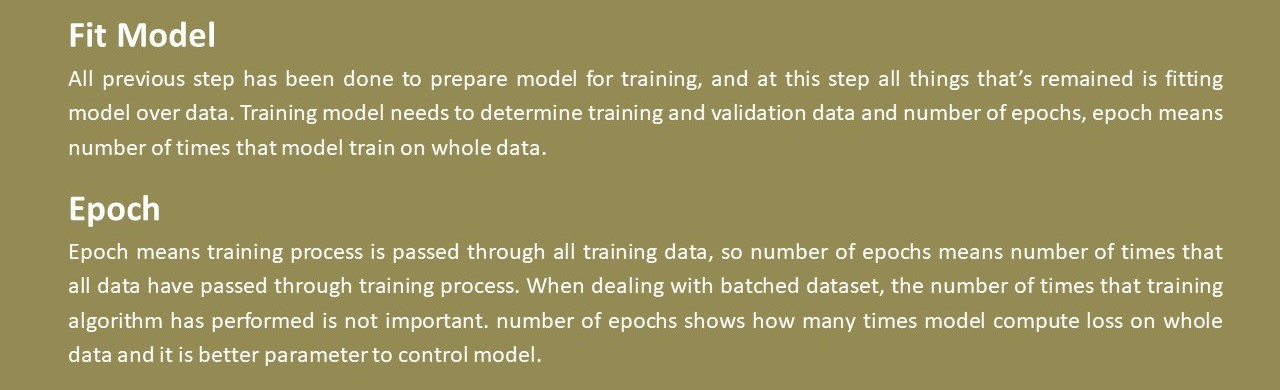

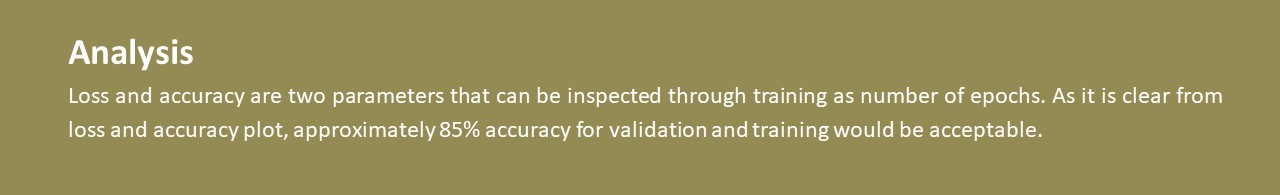

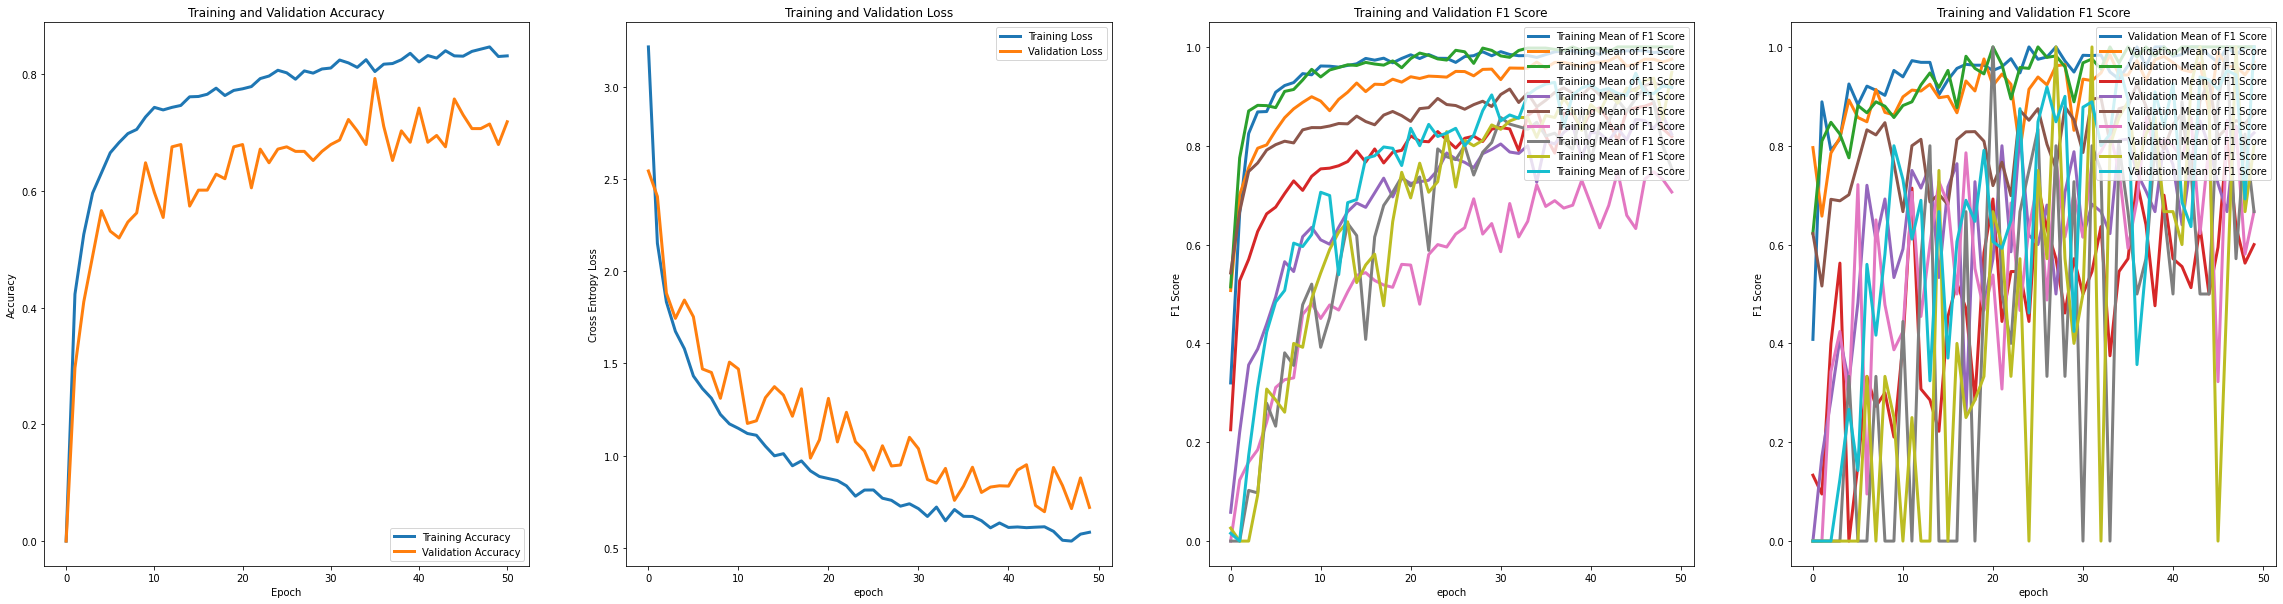

In [ ]:
acc = [0.] + history.history['accuracy']             #load training accuracy of the model   
val_acc = [0.] + history.history['val_accuracy']     #load validation accuarcy of the model
loss = history.history['loss']                                #load training loss of the model
val_loss = history.history['val_loss']                          #load validation loss of the model
f1_s =  history.history['f1_score']
val_f1_s = history.history['val_f1_score']
fig = plt.figure(figsize=(40, 10))
plt.subplot(1, 4, 1)                                          #plot accuarcy vs epochs
plt.plot(acc, label='Training Accuracy', linewidth=3)
plt.plot(val_acc, label='Validation Accuracy', linewidth=3)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 4, 2)                                         #plot loss vs epochs
plt.plot(loss, label='Training Loss', linewidth=3)
plt.plot(val_loss, label='Validation Loss', linewidth=3)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.xlabel("epoch")
plt.title('Training and Validation Loss')
plt.subplot(1, 4, 3)                                         #plot loss vs epochs
plt.plot(f1_s, label='Training Mean of F1 Score', linewidth=3)
#plt.plot(val_f1_s, label='Validation Mean of F1 Score', linewidth=3)
plt.legend(loc='upper right')
plt.ylabel('F1 Score')
plt.xlabel("epoch")
plt.title('Training and Validation F1 Score')
plt.subplot(1, 4, 4)                                         #plot loss vs epochs
#plt.plot(f1_s, label='Training Mean of F1 Score', linewidth=3)
plt.plot(val_f1_s, label='Validation Mean of F1 Score', linewidth=3)
plt.legend(loc='upper right')
plt.ylabel('F1 Score')
plt.xlabel("epoch")
plt.title('Training and Validation F1 Score')
plt.show()

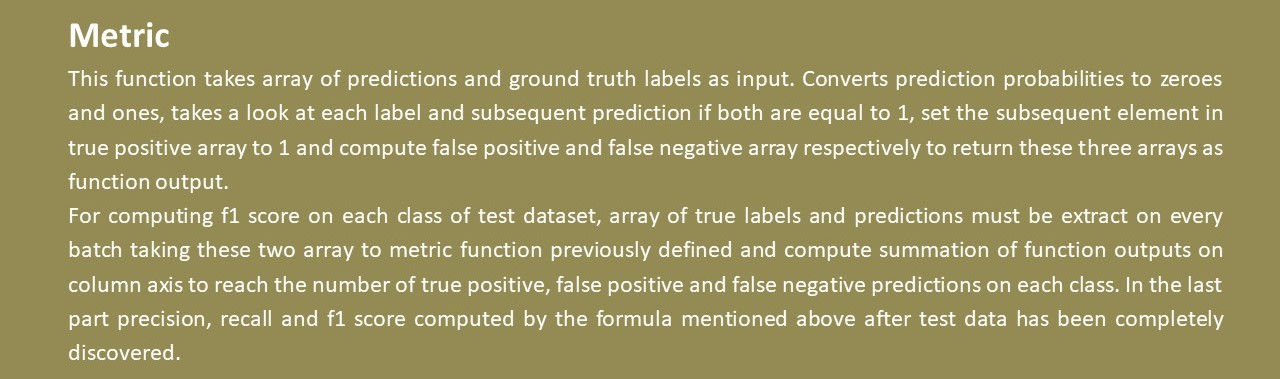

In [ ]:
def metrics(y_trues, preds):
  preds = preds >= 0.5
  tp = np.zeros_like(preds)
  fp = np.zeros_like(preds)
  fn = np.zeros_like(preds)
  for i in range(preds.shape[0]):
    for j in range(preds.shape[1]):
      if y_trues[i, j] == 1 and preds[i, j] == 1:
        tp[i, j] = 1
      elif y_trues[i, j] == 0 and preds[i, j] == 1:
        fp[i, j] = 1
      elif y_trues[i, j] == 1 and preds[i, j] == 0:
        fn[i, j] = 1
  return tp, fp, fn


In [ ]:
def F1_score(num_classes=10):
  k = 0
  tp = np.zeros((228, num_classes))
  fp = np.zeros((228, num_classes))
  fn = np.zeros((228, num_classes))
  for images, labels in test_data.take(-1):
    preds = model.predict(images)
    tp_1, fp_1, fn_1 = metrics(labels, preds)
    batch_size = tp_1.shape[0]
    tp[k: batch_size + k, :] += tp_1
    fp[k: batch_size + k, :] += fp_1
    fn[k: batch_size + k, :] += fn_1
    k += batch_size
  TP = np.sum(tp, axis=0)
  FP = np.sum(fp, axis=0)
  FN = np.sum(fn, axis=0)
  precision = TP/(TP + FP)
  recall = TP/(TP + FN)
  f1_score = 2*precision*recall/(precision + recall)
  return f1_score

In [ ]:
F1_score()